## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [43]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LogisticRegression


#Interpretability 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale


import warnings
warnings.filterwarnings('ignore')

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle

In [47]:
#Load dataset breast cancer
data = load_breast_cancer()

df = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
df.columns= features_name+['target']
df['target'] = df.target.astype('int32')
df.target = 1- df.target


In [49]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)


In [11]:
import numpy as np
m_corr = df[features_name].corr(method="spearman")
upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
df = df.drop(to_drop, axis=1)

In [13]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.iloc[:,:-1], df.target)
print(X_resampled.shape)

(424, 16)


In [15]:
#Train and test set
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [17]:
#Winsorize outliers
from scipy.stats.mstats import winsorize

def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)
    
for col in X_train.columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : mean_radius
 winsorization de la variable : mean_texture
 winsorization de la variable : mean_smoothness
 winsorization de la variable : mean_compactness
 winsorization de la variable : mean_symmetry
 winsorization de la variable : mean_fractal_dimension
 winsorization de la variable : radius_error
 winsorization de la variable : texture_error
 winsorization de la variable : smoothness_error
 winsorization de la variable : compactness_error
 winsorization de la variable : concave_points_error
 winsorization de la variable : symmetry_error
 winsorization de la variable : fractal_dimension_error
 winsorization de la variable : worst_smoothness
 winsorization de la variable : worst_symmetry
 winsorization de la variable : worst_fractal_dimension


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [25]:
#Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
class_svc = SVC(random_state=42, C=0.5, kernel='poly',degree=2)
class_svc.fit(X_train_sc, y_train)
print('Accuray train : ' + str(accuracy_score(y_train, class_svc.predict(X_train))))
print('Accuray test : ' + str(accuracy_score(y_test, class_svc.predict(X_test))))

Accuray train : 0.5162241887905604
Accuray test : 0.5529411764705883


C:\Users\valor\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\valor\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [27]:
#Prédiction pour un individu
class_svc.predict(X_test_sc[0].reshape(1,16))

array([0])

In [223]:
cvs_svc_rbf = cross_val_score(class_svc, X_train_sc, y_train, cv=5, scoring='accuracy')
#Get data output from cross_val_score
df_cross = pd.DataFrame(cvs_svc_rbf, columns=['accuracy'])
df_cross.index = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
df_cross


,accuracy
fold1,0.926471
fold2,0.852941
fold3,0.808824
fold4,0.823529
fold5,0.895522


In [225]:
# Calculate mean and standard deviation
mean_model = df_cross['accuracy'].mean()
std_model = df_cross['accuracy'].std()

# Print results
print(f"Le modèle a une accuracy moyenne de {mean_model:.4f} et un écart-type de {std_model:.4f}.")

Le modèle a une accuracy moyenne de 0.8615 et un écart-type de 0.0492.


#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [31]:
from sklearn.linear_model import SGDClassifier , LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_sc, y_train)


LogisticRegression(random_state=42)

In [57]:
#coefficients standardisés
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
beta = pd.DataFrame(np.abs(log_reg.coef_[0]),index=X_train_sc.columns,columns=['abs(coef)'])
beta.sort_values(by='abs(coef)', ascending=False)

,abs(coef)
mean_radius,2.210265
radius_error,1.775375
worst_symmetry,1.548291
concave_points_error,1.082079
mean_texture,1.078150
worst_fractal_dimension,0.869001
symmetry_error,0.765990
worst_smoothness,0.690944
fractal_dimension_error,0.667997
mean_compactness,0.637789


In [229]:
print(log_reg.coef_[0])

[-2.54943418 -1.25590724 -0.22186633 -0.96762669 -0.0057043   1.01096886
 -1.67767183  0.25119599 -0.02204544  0.30527558 -0.67375672  0.62509957
  0.59527255 -1.07243877 -0.87494588 -0.80592678]


In [231]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

In [280]:
log_reg.coef_[0]

array([-2.54943418, -1.25590724, -0.22186633, -0.96762669, -0.0057043 ,
        1.01096886, -1.67767183,  0.25119599, -0.02204544,  0.30527558,
       -0.67375672,  0.62509957,  0.59527255, -1.07243877, -0.87494588,
       -0.80592678])

In [252]:
print(pd.DataFrame(log_reg.coef_[0], index=X_train_sc.columns, columns=['coef']))


                             coef
mean_radius             -2.549434
mean_texture            -1.255907
mean_smoothness         -0.221866
mean_compactness        -0.967627
mean_symmetry           -0.005704
mean_fractal_dimension   1.010969
radius_error            -1.677672
texture_error            0.251196
smoothness_error        -0.022045
compactness_error        0.305276
concave_points_error    -0.673757
symmetry_error           0.625100
fractal_dimension_error  0.595273
worst_smoothness        -1.072439
worst_symmetry          -0.874946
worst_fractal_dimension -0.805927


In [93]:
y_predicted = log_reg.predict(X_train_sc)
# Évaluation du modèle
rmse = mean_squared_error(y_train, y_predicted)
r2 = r2_score(y_train, y_predicted)

print(f"Le modèle a un rmse de {rmse:.4f} et un R² de {r2:.4f}.")

Le modèle a un rmse de 0.1003 et un R² de 0.5986.


#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

In [59]:
df_interpret = pd.DataFrame(X_test_sc, columns = X_train_sc.columns)

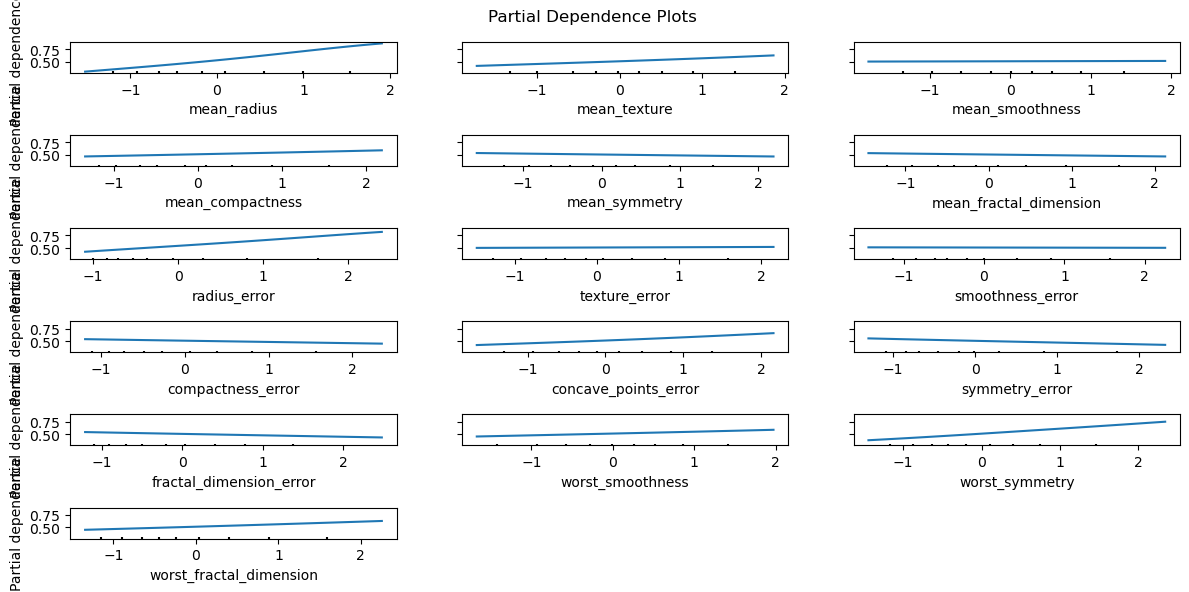

In [75]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay


# Définir nos variables d'intérêts dans une liste
features = X_train_sc.columns # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator(log_reg, # votre modèle
                                         X_train_sc, # Jeu d'entrainement
                                         features, # features
                                         kind="average", # Pour obtenir une PDP
                                         grid_resolution=50, #Nombre de points estimés pour le tracer de la courbe
                                         ax = ax1 # Paramètre de matplotlib
                                           )

plt.suptitle("Partial Dependence Plots ")
plt.tight_layout()
plt.subplots_adjust(hspace=2)
plt.show()



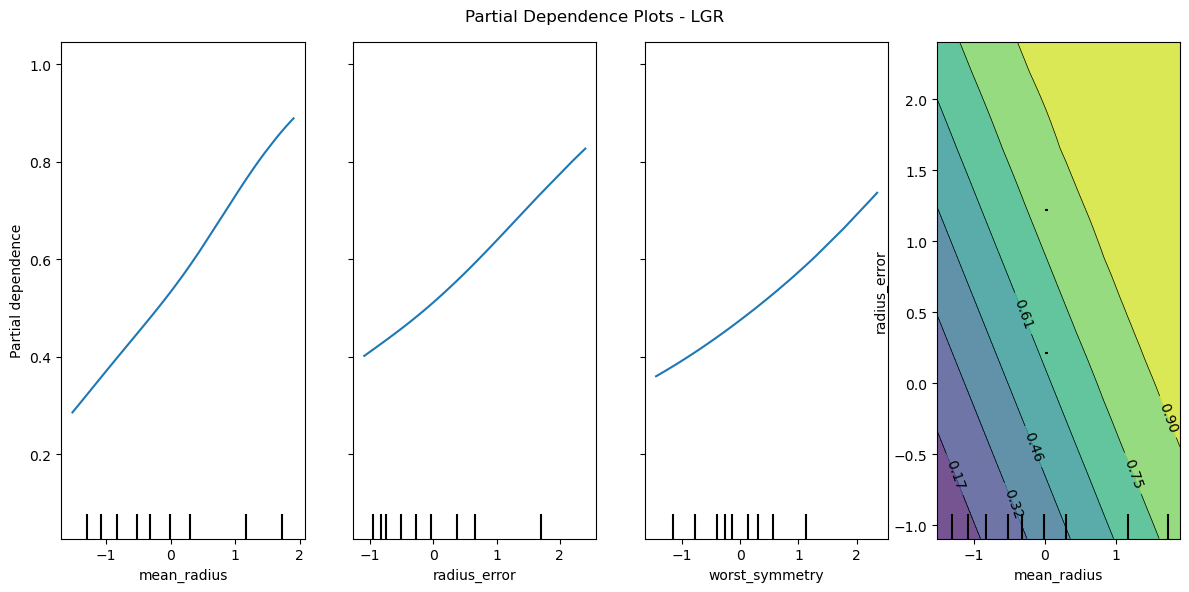

In [61]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["mean_radius","radius_error","worst_symmetry" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(log_reg,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=4
                                         )
plt.suptitle("Partial Dependence Plots - LGR")
plt.tight_layout()
plt.show()

In [81]:
print(log_reg_exp.feature_names)


[[-1.36513209 -0.83711788 -0.65532549 ...  0.54858311 -0.45959439
   0.55510838]
 [-0.8578438  -0.4106613  -1.14043326 ... -0.92034714 -0.29338563
  -0.63151032]
 [-0.57400393 -0.41579933  1.92299081 ...  0.52541386 -0.65232582
   0.21934857]
 ...
 [ 1.11091788 -0.33872886  0.12982459 ...  0.2566506   1.31565659
   0.03943632]
 [ 0.25033954 -0.11779353 -1.47197607 ... -1.19837811 -0.47373981
  -0.96325935]
 [ 0.45869008 -1.06319124 -0.22219355 ...  0.05276123 -1.15095209
  -0.7334988 ]]


array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='radius_error', ylabel='ALE'>]], dtype=object)

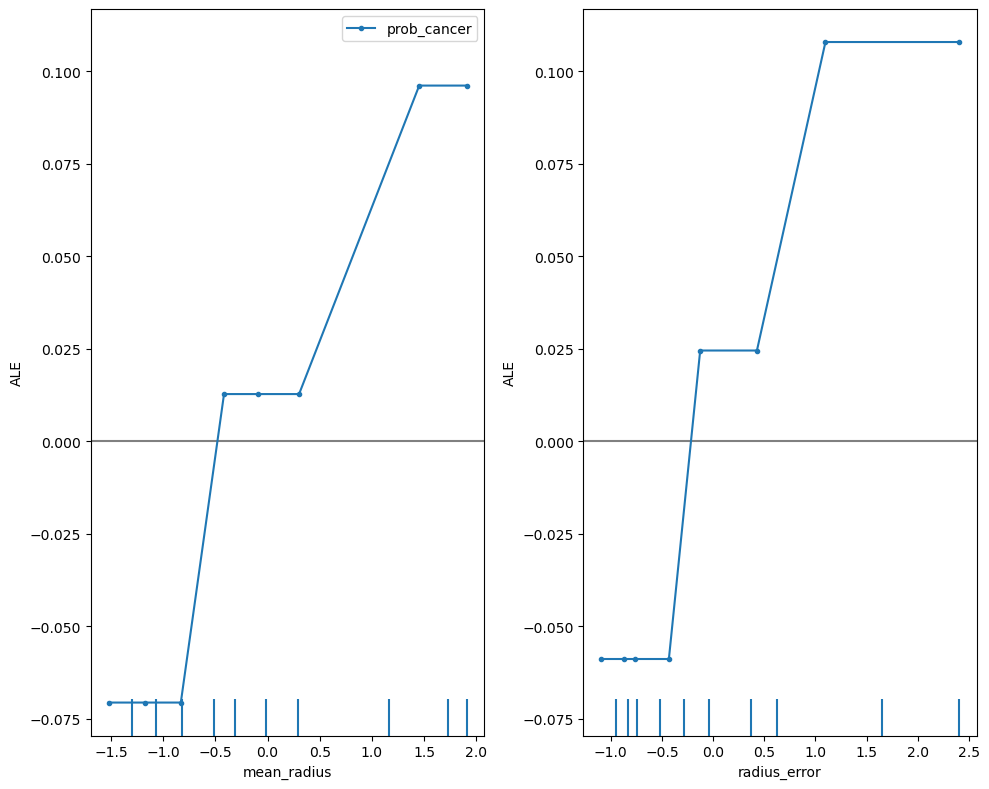

In [93]:
from alibi.explainers import ALE, plot_ale
lgr_ale = ALE(log_reg.predict, feature_names=X_train_sc.columns.tolist(), target_names=["prob_cancer"])
lgr_exp = lgr_ale.explain(X_test_sc, min_bin_points=10)
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(lgr_exp, features=["mean_radius","radius_error"], ax= ax1, targets=[0])


In [103]:
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.svm import LinearSVR

from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
h_stat = FriedmanHStatisticMethod()

h_stat.fit(log_reg, X_train_sc)

# Participation de votre feature et son interaction dans la variance globale

h_stat.plot(vis_type="bar_chart_ova")

ModuleNotFoundError: No module named 'artemis.interactions_methods'

In [111]:
!pip uninstall artemis


^C


In [115]:
from sklearn.inspection import permutation_importance

random_permutation = permutation_importance(log_reg, X_train_sc, y_train,n_repeats=30,random_state=0)



In [117]:
pd.DataFrame(random_permutation.importances_mean, index=X_train_sc.columns.tolist(), columns=['P-importance']).sort_values(by="P-importance", ascending=False)

,P-importance
mean_radius,0.110226
worst_symmetry,0.061160
radius_error,0.052606
mean_texture,0.025270
concave_points_error,0.018977
worst_fractal_dimension,0.013766
symmetry_error,0.002950
mean_compactness,0.002262
fractal_dimension_error,0.001573
worst_smoothness,0.001082


Text(0.5, 0.001, 'Feature importance : Loss function AUC')

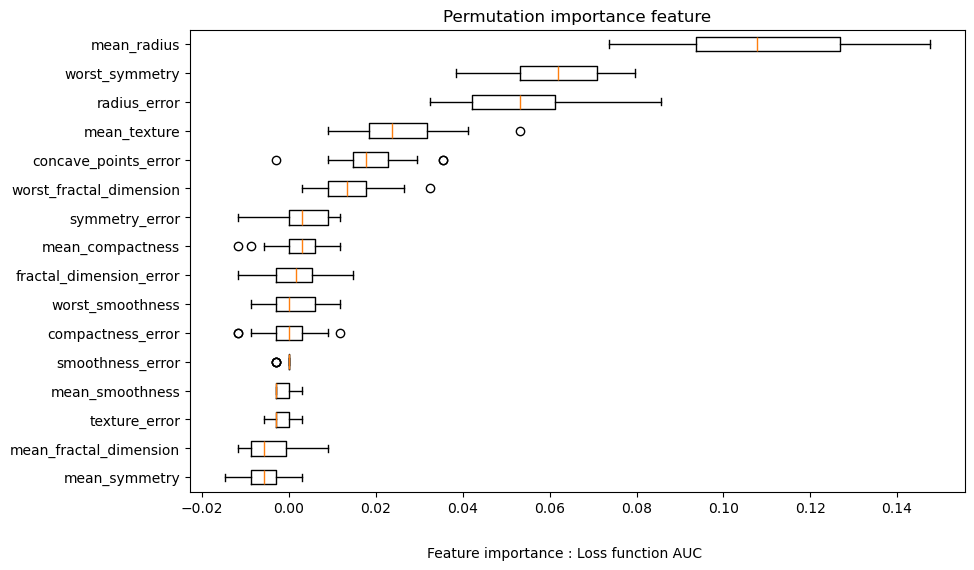

In [131]:
perm_sorted_idx = random_permutation.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    random_permutation.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train_sc.columns[perm_sorted_idx].tolist()
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')


#### 6) Commenter et discuter des limites

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales

In [ ]:
best_model = SVC(random_state=42, C=0.5, kernel='poly',degree=2)
best_model.fit(X_train_sc, y_train)

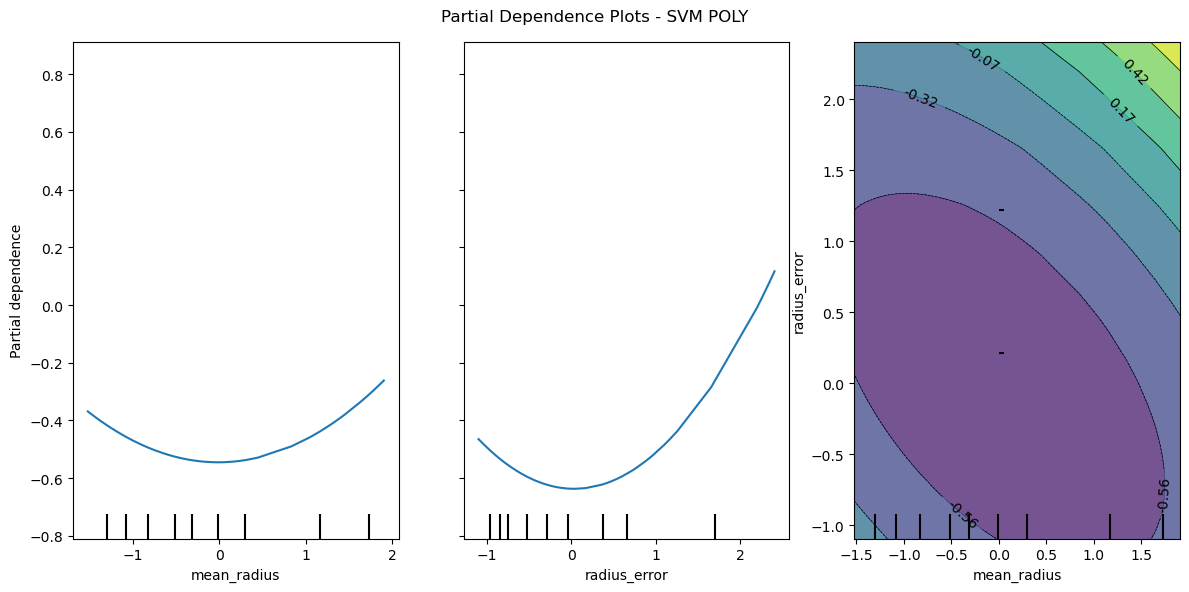

In [141]:
#Correction
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["mean_radius","radius_error" ,('mean_radius','radius_error')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_model,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3
                                         )
plt.suptitle("Partial Dependence Plots - SVM POLY")
plt.tight_layout()
plt.show()

In [143]:

svm_ale = ALE(best_model.predict, feature_names=X_train_sc.columns.tolist(), target_names=["prob_cancer"])
svm_exp = svm_ale.explain(X_test_sc, min_bin_points=10)

array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='mean_texture', ylabel='ALE'>]], dtype=object)

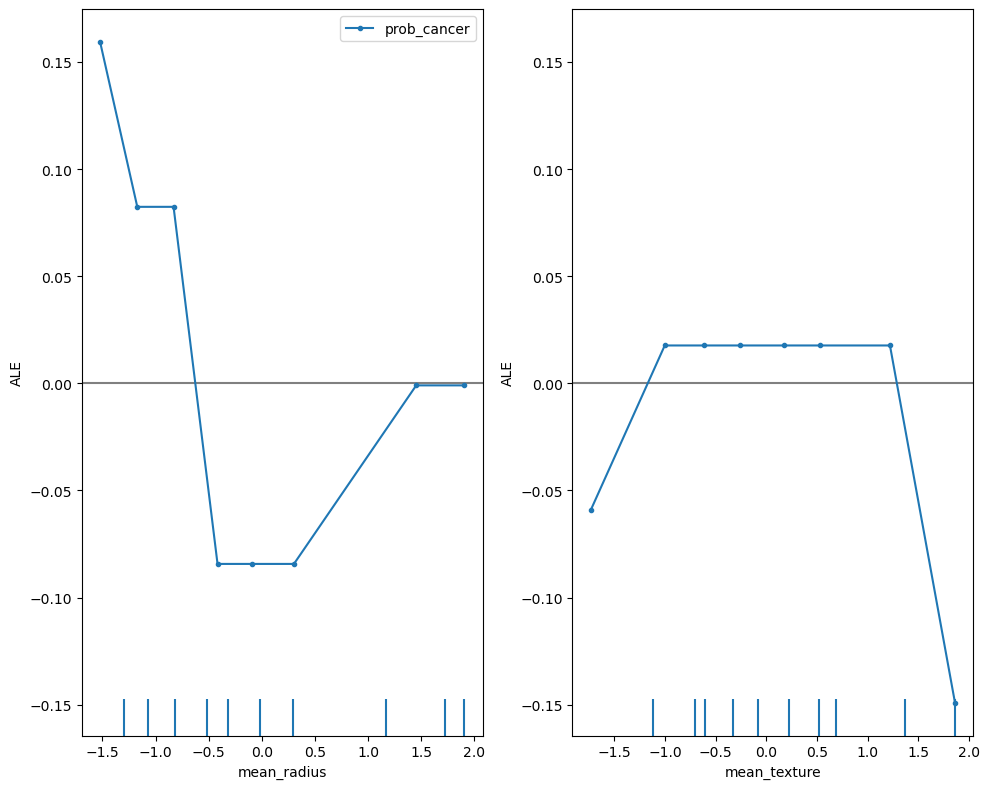

In [145]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(svm_exp, features=["mean_radius","mean_texture"], ax= ax1, targets=[0])

In [147]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(best_model, pd.DataFrame(X_test_sc, columns=training_features), batchsize=20)

NameError: name 'FriedmanHStatisticMethod' is not defined

In [149]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )

NameError: name 'h_stat' is not defined

In [151]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart",top_k=10 )

NameError: name 'h_stat' is not defined

In [153]:
result = permutation_importance(best_model, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring="accuracy"
                           )

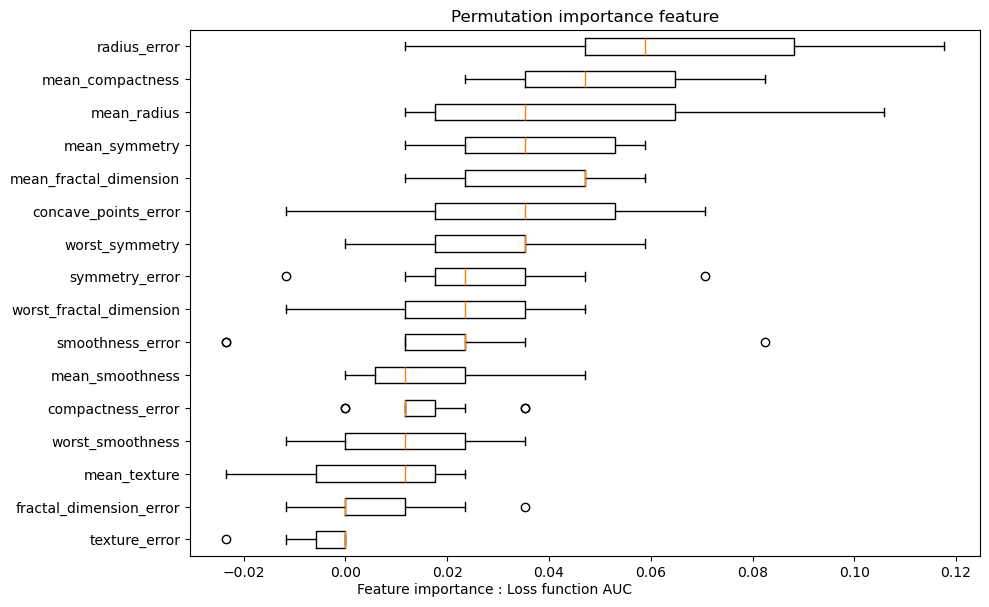

In [173]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train_sc.columns[perm_sorted_idx].tolist()
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()